## Longitudinal motion


Useful link (however the formulas used are not included here): http://kli.web.cern.ch/kli/USPAS_Lectures_Collective_Effects/Lectures/USPAS_01c_longitudinal_dynamics.pdf

### LHC main parameters 
https://cds.cern.ch/record/304825/files/p61.pdf [1]

In [1]:
import sys
from math import *
import numpy as np
import pandas as pd
from dotted_dict import DottedDict
import matplotlib.pyplot as plt
import NAFFlib as pnf

### Plotting parameters

In [2]:
params = {'legend.fontsize': 25,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Constants

In [3]:
m0 = 0.9382720813 # proton rest mass, [GeV/c^2] 
c = 299792458 # speed of light [m/s]
C0 = 26658.8832 # LHC circumference MAD-X twiss, [m]   , alternively use 26659 [m]
q  = 1.602176565e-19 # [C]

### Parameters of the reference particle

In [7]:
E_rest = m0 # [GeV]
E_0 = 7000. # total energy of the reference particle [GeV]
P0 = np.sqrt(E_0**2-E_rest**2)  # Acutally it is P0*C --> reference momentum times the speed of ligth --> [GeV]
gamma_0 =  E_0/E_rest # gamma realtivistic of the reference particle  # crosscheckd with mad
beta_0 = np.sqrt(1-1/gamma_0**2) # beta realtivistic of the reference particle
f_rev_0 = (beta_0*c)/C0 # revolution frequency [Hz]
T_rev_0 = 1/f_rev_0 # revolution period [s]

### Test for a particle with given momentum deviation
- Calculate the relativistic beta for a particle with delta specified by the user

In [8]:
delta = 1e-4

In [14]:
P = (1 + delta) * P0 #  # Acutally it is P*C --> momentum times the speed of ligth --> [GeV]
gamma = np.sqrt(1+(P/m0)**2)
beta = np.sqrt(1-1/gamma**2)

In [15]:
'The relativistic beta for a particle with delta = {} is {}'.format(delta, beta)

'The relativistic beta for a particle with delta = 0.0001 is 0.9999999910185872'

### Define the elements for the longitudinal motion 

In [16]:
def drift(eta, C0, z, delta):
    z1 =z - eta * delta * C0
    delta1 = delta
    
    return z1, delta1

In [17]:
def RF_map(P0, m0, beta_0, f_RF, c, lag, V_RF, E_0, z, delta):
    
    P = (1 + delta) * P0 #  # Acutally it is P*C --> momentum times the speed of ligth --> [GeV]
    gamma = np.sqrt(1+(P/m0)**2)
    beta = np.sqrt(1-1/gamma**2)    
    old_rvv = beta/beta_0
    
    # RF energy kick 
    k = 2 * np.pi * f_RF  /c
    tau = z / old_rvv / beta_0
    phase = lag * np.pi / 180. - k * tau
   
    energy = V_RF*np.sin(phase)
    
    
    deltabeta_0 = delta*beta_0
    ptaubeta_0 = np.sqrt(deltabeta_0**2+2*deltabeta_0*beta_0+1)-1
    ptaubeta_0 += energy / E_0 # energy kick
    ptau = ptaubeta_0 / beta_0

    
    delta1 = np.sqrt(ptau ** 2 + 2 * ptau / beta_0 + 1) - 1
    rvv = (1 + delta1) / (1 + ptaubeta_0)
    z1 = z* rvv / old_rvv
    
    
    return z1, delta1

### Define the parameters of the RF cavity

In [19]:
V_RF = 160e-3 # [GV]
lag = 180.# the lang angle of the cavity [degrees], phase_RF
f_RF = 400.8e6 # Hz

### Calculate the harmonic number

In [20]:
h_float  = f_RF/ f_rev_0
h = int(f_RF/ f_rev_0) 
print('The harmonic number is h={}'.format(h))
print('float h ={}'.format(h_float))

The harmonic number is h=35640
float h =35640.92490460356


### Synchrotron parameters

In [21]:
gamma_tr =  53.7102749510076 # MAD-X twiss
alpha_c = (1/(gamma_tr**2)) # compaction factor
eta = abs(alpha_c -1/(gamma_0**2) ) # slip factor
e_t = 0.001 # longitudinal emittance [m]

### Bunch and RF buncket parameters
1) $\beta_z$ : the longitudinal beta function (Courant-Snyder function) [m]. Wolski p.175
\begin{equation}
\beta_z = \frac{\sigma_z}{\sigma_{\delta}} = \frac{C_0 |\eta_p|}{2 \pi v_z}
\end{equation}
, where $C_0$ the circumference of the storage ring in [m] and $v_z$ the synchrotron tune, $\sigma_z$ the rms bunch length and $\sigma_{\delta}$ the rms energy spread of the bunch

2) bucket length [m] :
\begin{equation}
length = \frac{c}{f_{RF}}
\end{equation}
, where c is the speed of light in [m/s] and $f_R{RF}$ the frequency of the RF cavity in [Hz]

3) max bucket height (if you don't want the maximum, replace beta_0 with beta (maybe))
\begin{equation}
height = \beta_0 \frac{2 V_{RF}}{ \pi h \eta E_0}
\end{equation}




In [22]:
sigma_z = 0.0075 # [m] MAD-X for collisions at HL-LHC : cernbox/2019/7/HL_LH_mask_emilia.ipynb. Same for collisions at LHC, as shown in Table 2 a[1]
sigma_delta =  0.00011 # [m] relative energy spreead sigma_e/E  from MAD-X for HL-LHC : cernbox/2019/7/HL_LH_mask_emilia.ipynb. Also tou can use 2.5 in [eV*s] for LHC at 7 TeV.   

In [23]:
beta_z = sigma_z/sigma_delta #[m]
bucket_length = c/f_RF # [m]
max_bucket_height = beta_0*np.sqrt((2*V_RF)/(np.pi*h*eta*E_0)) # no units

### Limits of RF stationary bucket 
Assuming that is centered around 0 


1) Bunch length. c [m/s], f_RF [Hz]

In [24]:
z_left = - bucket_length/2. #-C0/(2.*h) # [m]
z_right =  bucket_length/2. #C0/(2.*h) # [m]

### Plot the RF bucket

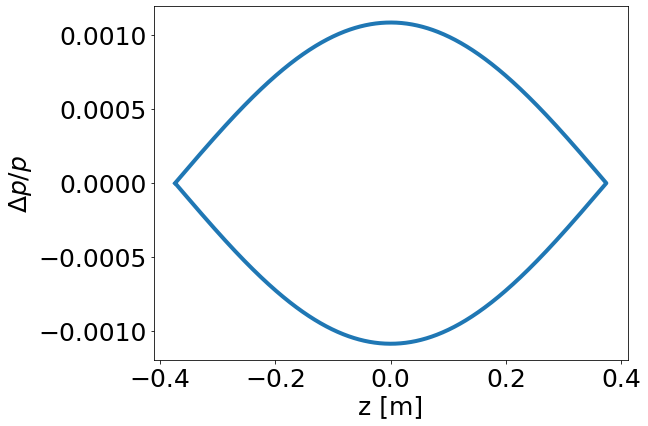

In [25]:
step = 0.001
z_list = []
delta_list = []

for zi in np.arange(z_left , z_right , step):
    delta_list.append(np.sqrt(V_RF * (np.cos(h * zi * 2 * np.pi / C0) + 1.) / (np.pi * h * abs(eta) * beta_0 * P0)))
    z_list.append(zi)
                      
for zi in np.arange(z_right, z_left , -step):
    delta_list.append(-np.sqrt(V_RF * (np.cos(h * zi * 2 * np.pi / C0) + 1.) / (np.pi * h * abs(eta) * beta_0 * P0)))
    z_list.append(zi)
                      
plt.plot(z_list, delta_list, linewidth =4)
plt.xlabel('z [m]')
plt.ylabel(r'$\Delta p / p$')

plt.show()


### Create the bunch 
Gaussian distribution 

In [26]:
n_particles = 1000
# create bunch
bunch = DottedDict()
bunch.z = np.zeros(n_particles)
bunch.delta = np.zeros(n_particles)
mu, sigma = 0.0, 1 # mean and standard deviation

z_initial = np.random.normal(mu, sigma, n_particles)*sigma_z
delta_initial = np.random.normal(mu, sigma, n_particles)*sigma_delta


bunch.z = z_initial
bunch.delta = delta_initial

In [27]:
bunch.z = z_initial
bunch.delta = delta_initial
df = pd.DataFrame({'turn':[], 'z':[], 'delta':[], 'y':[], 'py':[]})
# Append the initial values, not normalised
df = df.append({'turn':0, 'z':bunch.z, 'delta':bunch.delta}, ignore_index = True)

### Tracking and plotting of the phase space

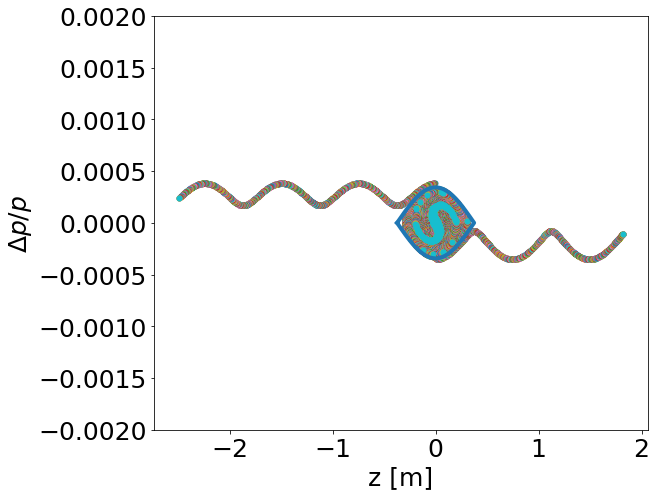

In [112]:
fig, ax = plt.subplots(1,1,figsize=(9,7))

turns = 1000
for turn in range(0, turns): #plot for the first 10 turns
    ax.scatter(bunch.z, bunch.delta)
    ax.set_xlabel('z [m]')
    ax.set_ylabel(r'$\Delta p /p$')
    bunch.z, bunch.delta = drift(eta, C0, bunch.z, bunch.delta)
    bunch.z, bunch.delta = RF_map(P0, m0, beta_0, f_RF, c, lag, V_RF, E_0, bunch.z, bunch.delta)
    
    df = df.append({'turn':turn, 'z':bunch.z, 'delta':bunch.delta}, ignore_index = True)
                      
plt.plot(z_list,delta_list, linewidth = 4)

plt.ylim(-2e-3, 2e-3)
plt.tight_layout()

df.to_pickle('.pkl')

### Calculate theoretically synchtotron tune
- Theoretically it should be :
\begin{equation}
Q_s = \frac{f_s}{f_{rev}} = \frac{\omega_s}{\omega_0}
\end{equation}
, where $f_s$ and $\omega_s$ (angular frequency) is the synchrotron frquency in Hz and radians per second respectively and $f_{rev}$ and $\omega_0$ (angular frequency) is the revolution frquency in Hz and radians per second respectively. 
Note that :
\begin{equation}
\omega_0 = 2 \pi f_{rev}
\end{equation}
and
\begin{equation}
\omega_s = 2 \pi f_{s}
\end{equation}


In [22]:
Q_s = 1.9e-3 # during collisions as obtained from [1]

### Estimate synchroton tune using NAFF
The particles that are lost are excluded

In [76]:
z_data = {}
delta_data = {}
for particle in range(n_particles):
    z_data[particle] = []
    delta_data[particle] = []

In [77]:
for particle in range(n_particles):
    for turn in range(turns):
        z_data[particle].append(df.at[turn,'z'][particle])
        delta_data[particle].append(df.at[turn,'delta'][particle])

In [78]:
lost_particles = []
Qs_list = []

for particle in range(n_particles):
    if np.isnan(z_data[particle]).any() or np.isnan(delta_data[particle]).any():
        lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_z = z_data[particle]  
       
        Qs_list.append(pnf.get_tune(np.array(signal_z)))

### Calculate the average action for each particle over the number of turns

In [79]:
# the indeces 1, 2 corrsepond to the first and second time integral respectively
flag_average_actions = True
if flag_average_actions:
    Jz_mean = [] # Here you will save the average actions for each particle for every turn
    Jz_data = {}
    for particle in range(n_particles):
        Jz_data[particle] = []
        Jz_data[particle] = (np.array(z_data[particle])/sqrt(beta_z))**2 + (np.array(delta_data[particle])*sqrt(beta_z))**2
        Jz_mean.append(np.nanmean(Jz_data[particle]))

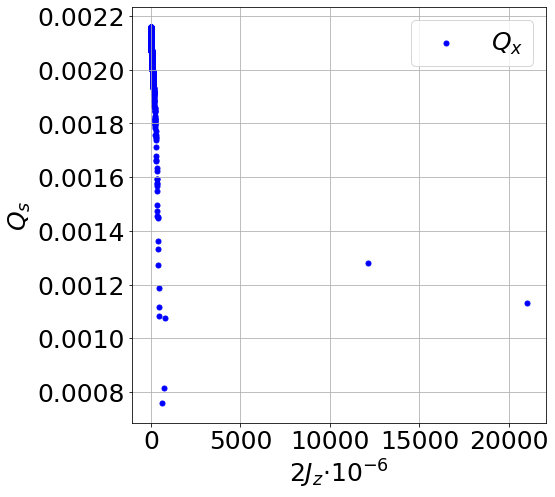

In [80]:
fig, ax = plt.subplots(1,1,figsize=(8,7))

ax.hlines(Q_s, min(Jz_mean), max(Jz_mean) , colors = 'r')


ax.scatter(np.array(Jz_mean)*1e6, Qs_list, c='b', label=r'$Q_x$') 
#ax.set_title(r'$\Delta={}, g={}, \Delta Q_x={:.3f}, \Delta Q_y={}$'.format(Delta, gain, 0.005, 0))
ax.set_xlabel(r'$2J_z$'+r'$\cdot 10^{-6}$')
ax.set_ylabel(r'$Q_s$')
#ax.set_ylim(0.00185, 0.01)
#ax.set_xlim(min(Jz_mean), max(Jz_mean))
ax.grid()



plt.legend()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('tune_shift')